<a href="https://colab.research.google.com/github/almostoutlier/Projects/blob/main/TikTok_Misinformation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/data/tiktok_dataset.csv")
dataset.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [ ]:
dataset.shape

(19382, 12)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [ ]:
dataset.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [ ]:
dataset.nunique()

#                           19382
claim_status                    2
video_id                    19382
video_duration_sec             56
video_transcription_text    19012
verified_status                 2
author_ban_status               3
video_view_count            15632
video_like_count            12224
video_share_count            9231
video_download_count         4336
video_comment_count          2424
dtype: int64

In [ ]:
dataset.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [ ]:
data = dataset.dropna(axis=0)

In [ ]:
data["claim_status"].value_counts(normalize=True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

In [ ]:
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

<ipython-input-11-a924429c728d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_length'] = data['video_transcription_text'].str.len()


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [ ]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


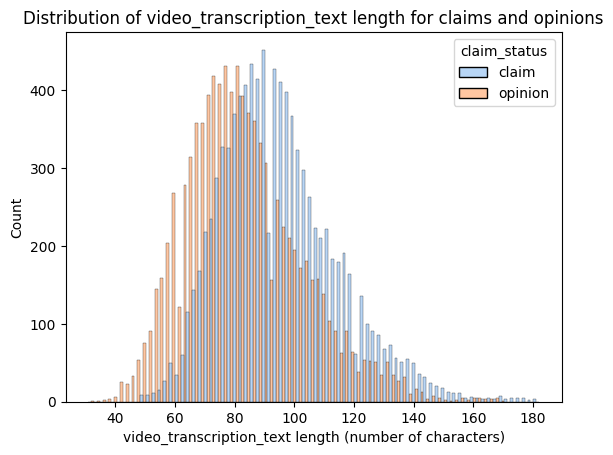

In [ ]:
sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

In [ ]:
X = data.copy()
X = X.drop(['#', 'video_id'], axis=1)
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


In [ ]:
y = X['claim_status']

In [ ]:
X = X.drop(['claim_status'], axis=1)
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(11450, 11)
(11450,)
(3817, 11)
(3817,)
(3817, 11)
(3817,)


In [ ]:
count_vec = CountVectorizer(ngram_range=(2, 3), max_features=15, stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [ ]:
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered tv,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,40,609220.0,70478.0,23182.0,250.0,22.0,134,False,True,False,...,0,0,0,0,0,1,0,0,0,0
1,22,235246.0,36353.0,2844.0,682.0,368.0,101,True,False,False,...,0,0,0,0,0,0,0,0,0,0
2,19,628011.0,260769.0,26640.0,2963.0,1782.0,117,False,False,False,...,1,0,0,1,0,0,0,0,0,0
3,58,30651.0,2649.0,725.0,59.0,5.0,116,False,False,False,...,0,0,0,0,0,1,0,0,0,0
4,40,129607.0,5473.0,1526.0,47.0,1.0,85,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered tv,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,27,755435.0,194627.0,32197.0,508.0,271.0,98,False,False,True,...,0,0,0,0,0,0,0,0,0,0
1,50,4487.0,874.0,207.0,17.0,2.0,126,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,24,518017.0,73294.0,26943.0,199.0,103.0,110,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,18,820820.0,496974.0,193626.0,2566.0,819.0,106,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,51,698365.0,463388.0,167737.0,6237.0,1355.0,105,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()


,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,48,650262.0,16903.0,660.0,49.0,25.0,110,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,10,8581.0,3747.0,1192.0,32.0,11.0,77,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,54,4343.0,495.0,54.0,3.0,1.0,119,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,18,9117.0,301.0,117.0,4.0,0.0,68,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,19,933.0,4.0,0.0,0.0,0.0,99,False,False,False,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', annot_kws={'fontsize': 10})
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [ ]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: user 8min 5s, sys: 1.08 s, total: 8min 6s
Wall time: 8min 29s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'f1', 'precision', 'accuracy', 'recall'})

In [ ]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

XGBoost Model

In [ ]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [ ]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: user 2min 34s, sys: 1.47 s, total: 2min 35s
Wall time: 1min 33s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'f1', 'precision', 'accuracy', 'recall'})

In [ ]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

Random Forest

In [ ]:
y_pred = rf_cv.best_estimator_.predict(X_val_final)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1890
           1       1.00      1.00      1.00      1927

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



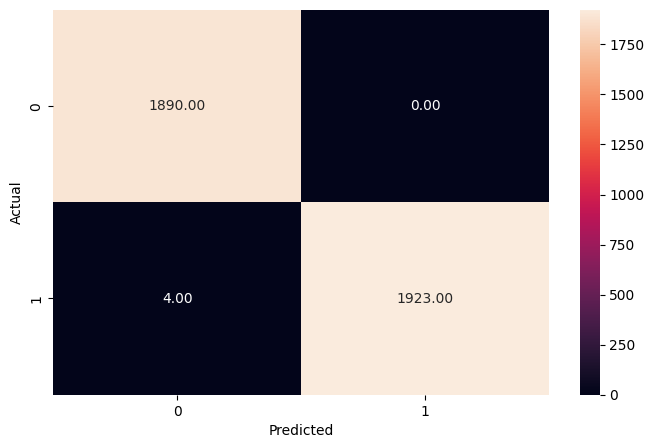

In [ ]:
metrics_score(y_val,y_pred)

In [ ]:
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1890
           1       1.00      0.99      1.00      1927

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



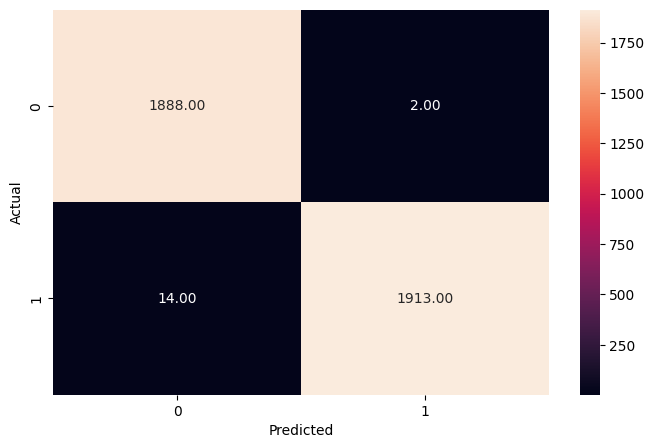

In [ ]:
metrics_score(y_val,y_pred)

Decided on Random Forest

In [ ]:
y_pred = rf_cv.best_estimator_.predict(X_test_final)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1873
           1       1.00      1.00      1.00      1944

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



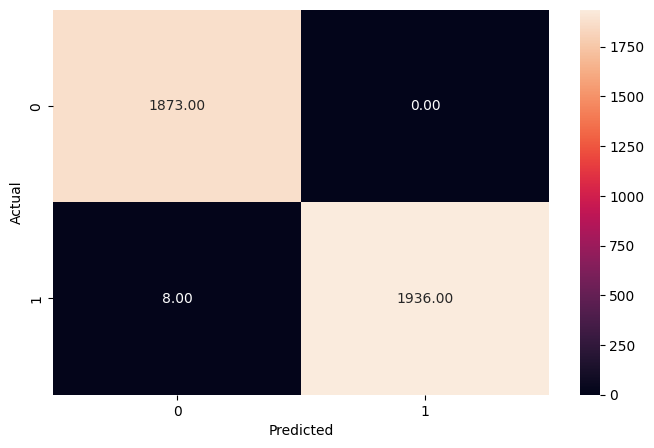

In [ ]:
metrics_score(y_test,y_pred)

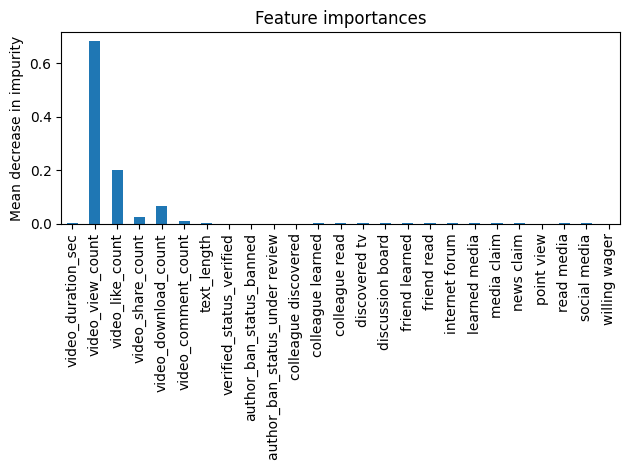

In [ ]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
dataset = pd.read_csv("/content/drive/MyDrive/data/tiktok_dataset.csv")
dataset = dataset.dropna()

# Label encoding: Convert 'claim_status' to binary labels
dataset['claim_status'] = dataset['claim_status'].replace({'opinion': 0, 'claim': 1})

# Text and numerical features
X_text = dataset['video_transcription_text']
X_numerical = dataset[['video_duration_sec', 'video_view_count', 'video_like_count',
                       'video_share_count', 'video_download_count', 'video_comment_count']].values
y = dataset['claim_status'].values

<ipython-input-3-afa6a478b0e6>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['claim_status'] = dataset['claim_status'].replace({'opinion': 0, 'claim': 1})


In [6]:

# Tokenization and padding for text data
max_words = 10000  # Vocabulary size
max_len = 100      # Maximum length of a sequence

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text)
X_text_seq = tokenizer.texts_to_sequences(X_text)
X_text_padded = tf.keras.preprocessing.sequence.pad_sequences(X_text_seq, maxlen=max_len, padding='post')

# Combine numerical and text features
X_combined = np.hstack((X_text_padded, X_numerical))

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Define text input
text_input = tf.keras.Input(shape=(max_len,), name='text_input')
embedded_text = tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len)(text_input)
text_features = tf.keras.layers.Flatten()(embedded_text)

# Define numerical input
num_input = tf.keras.Input(shape=(X_numerical.shape[1],), name='num_input')

# Combine both inputs
combined = tf.keras.layers.Concatenate()([text_features, num_input])
dense_1 = tf.keras.layers.Dense(64, activation='relu')(combined)
dropout_1 = tf.keras.layers.Dropout(0.5)(dense_1)
dense_2 = tf.keras.layers.Dense(32, activation='relu')(dropout_1)
dropout_2 = tf.keras.layers.Dropout(0.3)(dense_2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_2)

# Create model
model = tf.keras.Model(inputs=[text_input, num_input], outputs=output)


In [8]:

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    [X_train[:, :max_len], X_train[:, max_len:]],  # Split text and numerical data
    y_train,
    validation_data=([X_val[:, :max_len], X_val[:, max_len:]], y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8220 - loss: 155.5054 - val_accuracy: 0.9935 - val_loss: 0.1826
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9815 - loss: 2.3119 - val_accuracy: 0.9940 - val_loss: 0.0650
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9869 - loss: 0.2980 - val_accuracy: 0.9937 - val_loss: 0.0419
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9912 - loss: 0.2575 - val_accuracy: 0.9840 - val_loss: 0.0487
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9903 - loss: 0.1275 - val_accuracy: 0.9942 - val_loss: 0.0254
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9903 - loss: 0.0432 - val_accuracy: 0.9948 - val_loss: 0.0313
Epoch 7/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9904 - loss: 0.5790 - val_accuracy: 0.9945 - val_loss: 0.0293
Epoch 8/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9930 - loss: 0.0402 - val_

ValueError: Layer "functional_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 106) dtype=float32>]

In [10]:
test_loss, test_accuracy = model.evaluate(
    [X_test[:, :max_len], X_test[:, max_len:]],
    y_test
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9954 - loss: 0.0263
Test Loss: 0.02694053389132023
Test Accuracy: 0.9952842593193054


In [11]:
# Split the test data into text and numerical inputs
X_test_text = X_test[:, :max_len]  # Extract the text part
X_test_num = X_test[:, max_len:]   # Extract the numerical part

# Make predictions
y_pred = (model.predict([X_test_text, X_test_num]) > 0.5).astype("int32")

# Print predictions or use for evaluation
print("Predictions:", y_pred)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predictions: [[0]
 [1]
 [1]
 ...
 [1]
 [1]
 [0]]


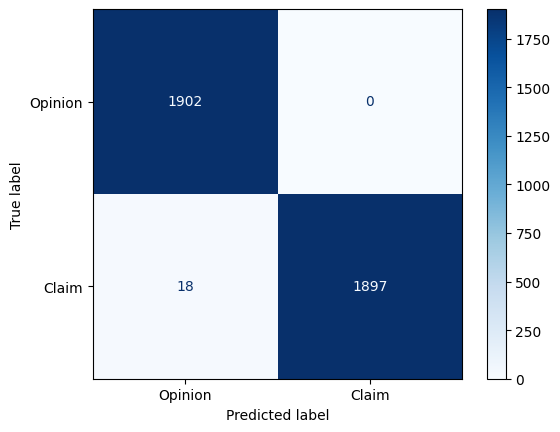

              precision    recall  f1-score   support

     Opinion       0.99      1.00      1.00      1902
       Claim       1.00      0.99      1.00      1915

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



In [12]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=['Opinion', 'Claim']).plot(cmap="Blues")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Opinion', 'Claim']))